__Authors__: Federica Papa, Francesco Daquino, Francesco Maggio, Ondrej Krasnansky, Sandro Cantasano Martino. 

---

# Text Classification with BERT

In [1]:
#!pip install datasets

In [2]:
import csv
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import Dataset
from sklearn.model_selection import train_test_split


#Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification


import tensorflow as tf
import tensorflow_hub as hub

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import time

from distutils.version import LooseVersion as LV
import io
import os
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, learning_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, make_scorer
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, PrecisionRecallDisplay

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""

print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 2.1.0+cu118 Device: cuda [Tesla T4]


<ipython-input-4-d1a1187c676c>:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert(LV(torch.__version__) >= LV("1.0.0"))


### loading a dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#we used colab execution environment to work with T4 GPU and run the following codes

import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from distutils.version import LooseVersion as LV

from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/df_preprocessed.csv")
df.head(2)

,tweet,is_hate_speech,dataset,retweet_count,favorite_count,is_reply,is_quote,statuses_count,followers_count,friends_count,...,Hash_words_ad,clean_tweet,clean_anonymized_description,tweet_len,word_count,tokenized_text,pos_tags,lemmatized_text,stemmed_text,swear_word_bin
0,@unknown Con tutte le denunce che si sta becca...,1,0,0.0,6.0,1.0,0.0,554.0,748.0,753.0,...,No hashtags,Con tutte le denunce che si sta beccando Salv...,Avete presente quegli stereotipi sui siciliani...,120,20,"['denunce', 'beccando', 'Salvini', 'rischia', ...","[('denunce', 'NOUN'), ('beccando', 'VERB'), ('...","['denuncia', 'beccare', 'Salvini', 'rischiare'...","['denunc', 'becc', 'salvin', 'risc', 'aument',...",0
1,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,0,154.0,448.0,0.0,0.0,35043.0,10838.0,4535.0,...,No hashtags,PRESCRIZIONE I tre magi hanno trovato laccord...,Prof di latino e Deputata PDAma lo sport la Ro...,255,46,"['PRESCRIZIONE', 'tre', 'magi', 'trovato', 'la...","[('PRESCRIZIONE', 'VERB'), ('tre', 'NUM'), ('m...","['PRESCRIZIONE', 'tre', 'mago', 'trovare', 'la...","['prescrizion', 'tre', 'mag', 'trov', 'laccord...",0


In [7]:
df.columns

Index(['tweet', 'is_hate_speech', 'dataset', 'retweet_count', 'favorite_count',
       'is_reply', 'is_quote', 'statuses_count', 'followers_count',
       'friends_count', 'anonymized_description', 'device',
       'Weighted_Engagement', 'Hash_words_tweet', 'Hash_words_ad',
       'clean_tweet', 'clean_anonymized_description', 'tweet_len',
       'word_count', 'tokenized_text', 'pos_tags', 'lemmatized_text',
       'stemmed_text', 'swear_word_bin'],
      dtype='object')

In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""

print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 2.1.0+cu118 Device: cuda [Tesla T4]


<ipython-input-9-d1a1187c676c>:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert(LV(torch.__version__) >= LV("1.0.0"))


### Data partitioning for binary classification

In [10]:
df['clean_tweet']

0        Con tutte le denunce che si sta beccando Salv...
1       PRESCRIZIONE  I tre magi hanno trovato laccord...
2       Il m5s ha votato contro le unionicivili adduce...
3       La Lega e il m5s stanno dando a bere allopinio...
4       Che cosa cambia questa legge Caro  con il decr...
                              ...                        
9917     Esatto brava  ti dico di piu i nazisti nel 19...
9918     Togliere la parola non vaccinati e mettere eb...
9919      Lo sai o no che i musulmani riconoscono Cris...
9920    Berlino  Memoriale per gli ebrei assassinati d...
9921      Solo un terone dal culetto olivastro bruciat...
Name: clean_tweet, Length: 9922, dtype: object

In [11]:
# some extra cleaning operations
def clean_tokens(tokens):

    """
    It cleans the tokens from unrelevant characters
    """
    tokens = re.sub(r"http[s]*\S+", "", tokens) #removing urls
    tokens = re.sub(r"[^\w\s'!.,]", '', tokens)
    tokens = re.sub('\d\s*star[s]?', '', tokens) # removing ratings from reviews
    tokens = re.sub(r'<.*?>', '', tokens) #removing HTMLS
    tokens = re.sub(r"\\", "", tokens) #removing \ character
    tokens = re.sub(r"\n", "", tokens) #removing new line characters
    tokens = re.sub(r'\b\d+\b', '', tokens) #removing numbers
    tokens = re.sub(r'spoiler[s]?', '', tokens) #removing spoiler alert
    tokens = re.sub('\S*\d+\S*', '', tokens) # removing words with still numbers inside
    tokens = re.sub("(.)\\1{2,}", r"\1", tokens) #removing extra characters
    tokens = re.sub("[.,'!]\s(\b)", r"\1", tokens) #removing punctuation that was left without words
    tokens = re.sub("^[.,]\s", '', tokens) #removing punctuation at the start of the line if present
    tokens = re.sub("[.,]\s?$", '', tokens) #removing punctuation at the end of the line if present
    tokens = re.sub(r'([.,])(\S)', r'\1 \2', tokens) # adding a space after punctuation
    tokens = re.sub("(\s){1,}", r"\1", tokens) #removing extra spaces
    tokens = re.sub(r"\s([.,!])", r"\1", tokens) # removing spaces before punctuation
    tokens = re.sub(r"([.,]){1,}", r"\1", tokens) # removing extra commas and dots
    tokens = re.sub(r"\s('[mst])", r"\1", tokens) # removing spaces before the apostrophe

    return tokens.strip() #.lower() 


df['clean_tweet'] = df['clean_tweet'].apply(lambda x: clean_tokens(x))

In [12]:
df['clean_tweet']

0       Con tutte le denunce che si sta beccando Salvi...
1       PRESCRIZIONE I tre magi hanno trovato laccordo...
2       Il ha votato contro le unionicivili adducendo ...
3       La Lega e il stanno dando a bere allopinione p...
4       Che cosa cambia questa legge Caro con il decre...
                              ...                        
9917    Esatto brava ti dico di piu i nazisti nel cerc...
9918    Togliere la parola non vaccinati e mettere ebr...
9919    Lo sai o no che i musulmani riconoscono Cristo...
9920    Berlino Memoriale per gli ebrei assassinati dE...
9921    Solo un terone dal culetto olivastro bruciato ...
Name: clean_tweet, Length: 9922, dtype: object

In [13]:
X = df['clean_tweet']
y = df['is_hate_speech']
x_train, x_test, y_train_bin, y_test_bin = train_test_split(X, y, stratify = y, test_size=0.3, random_state=0)

## Preparation of text for BERT

The tokenizer is already fit on the same dataset on which BERT has been pretrained and it is included in the BERT model.
To be properly handled by BERT we need to add the `[CLS]` token at the beginning of text.

In [14]:
sentences_train = ["[CLS] " + s for s in x_train]
sentences_test = ["[CLS] " + s for s in x_test]
labels_train = [1 if value else 0 for value in y_train_bin]
labels_test  = [1 if value else 0 for value in y_test_bin]

Next we use the BERT tokenizer to convert the sentences into tokens that match the data BERT was trained on.

In [15]:
#prova con modello mBERT

from transformers import BertTokenizer, BertModel

# Carica il tokenizzatore e il modello mBERT
BERTMODEL = 'bert-base-multilingual-uncased'
#BERTMODEL = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(BERTMODEL, do_lower_case=True)
tokenizer

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-base-multilingual-uncased', vocab_size=105879, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [16]:
from tqdm import tqdm

tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(sentences_test)]

100%|██████████| 2977/2977 [00:01<00:00, 1513.35it/s]


In [17]:
print ("The full tokenized first training sentence:")
print (tokenized_train[0])

The full tokenized first training sentence:
['[CLS]', 'si', 'apre', 'il', 'per', 'questo', 'il', 'per', 'altro', 'ma', 'a', 'pochi', 'giorni', 'manca', '##no', 'decret', '##i', 'ord', '##inan', '##ze', 'e', 'protocol', '##li', 'di', 'governo', 'regioni', 'e', 'comuni', 'da', 'interpretar', '##e', 'e', 'ris', '##pet', '##tare', 'ci', 'fate', 'sapere', '##gra', '##zie', 'ripresa', 'decreto', '##rita', '##rdo']


Now we set the maximum sequence lengths for our training and test sentences as `MAX_LEN_TRAIN` and `MAX_LEN_TEST`. The maximum length supported by the used BERT model is 512.

The token `[SEP]` is another special token required by BERT at the end of the sentence.

In [18]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 512

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test]

print ("The truncated tokenized first training sentence:")
print (tokenized_train[0])

The truncated tokenized first training sentence:
['[CLS]', 'si', 'apre', 'il', 'per', 'questo', 'il', 'per', 'altro', 'ma', 'a', 'pochi', 'giorni', 'manca', '##no', 'decret', '##i', 'ord', '##inan', '##ze', 'e', 'protocol', '##li', 'di', 'governo', 'regioni', 'e', 'comuni', 'da', 'interpretar', '##e', 'e', 'ris', '##pet', '##tare', 'ci', 'fate', 'sapere', '##gra', '##zie', 'ripresa', 'decreto', '##rita', '##rdo', 'SEP']


Next we use the BERT tokenizer to convert each token into an integer index in the BERT vocabulary. We also pad any shorter sequences to `MAX_LEN_TRAIN` or `MAX_LEN_TEST` indices with trailing zeros.


In [19]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test])

print ("The indices of the first training sentence:")
print (ids_train[0])

The indices of the first training sentence:
[  101 10193 73194 10145 10174 12469 10145 10174 17574 10507   143 31944
 22800 58506 10329 34840 10116 33042 39513 10732   147 33212 10408 10120
 15172 47187   147 28973 10141 47599 10111   147 71869 18268 20300 11200
 32878 84768 33711 14139 93298 23168 25608 32268   100     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


BERT also requires *attention masks*, with 1 for each real token in the sequences and 0 for the padding:

In [20]:
amasks_train, amasks_test = [], []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)

for seq in ids_test:
  seq_mask = [float(i>0) for i in seq]
  amasks_test.append(seq_mask)

In [21]:
print(amasks_test[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

We use scikit-learn's train_test_split() to use 10% of our training data as a validation set, and then convert all data into torch.tensors.

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42,
                                                     test_size=0.1) #20%
(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

#trasformo train test e val in toch object
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(labels_test)
test_masks  = torch.tensor(amasks_test)

Next we create PyTorch *DataLoader*s for all data sets.

For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

Il modello viene addestrato su tutti i dati del set di addestramento. La dimensione del batch controlla quanti di questi dati vengono utilizzati in ogni iterazione di addestramento. L'utilizzo di un campionatore casuale (RandomSampler) per il set di addestramento assicura che il modello veda diverse combinazioni di dati in ogni iterazione, migliorando la generalizzazione del modello.

In [24]:
BATCH_SIZE = 32

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'documents')

Datasets:
Train: 6250 documents
Validation: 695 documents
Test: 2977 documents


## BERT MODEL INITIALIZATION

We now load a pretrained BERT model with a single linear classification layer added on top.

In [25]:
# Check GPU Availability:
# Verify that your GPU is recognized by your system and is available for use.
# You can use the following command to check if your GPU is visible to PyTorch:

import torch
print(torch.cuda.is_available())

True


In [26]:
model = BertForSequenceClassification.from_pretrained(BERTMODEL, num_labels=2)

model.cuda() #uso cuda per lavorare con GPU
print('Pretrained BERT model "{}" loaded'.format(BERTMODEL))

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained BERT model "bert-base-multilingual-uncased" loaded


In [27]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

rilevante:
act function
n of feature
n of embedding

We set the remaining hyperparameters needed for fine-tuning the pretrained model:
 * EPOCHS: the number of training epochs in fine-tuning
   (recommended values between 2 and 4)
 * WEIGHT_DECAY: weight decay for the Adam optimizer
 * LR: learning rate for the Adam optimizer (2e-5 to 5e-5 recommended)
 * WARMUP_STEPS: number of warmup steps to (linearly) reach the set learning rate

We also need to grab the training parameters from the pretrained model.

In [28]:
# param_grid = {
#               'weight_decay': [0.01, 0.1, 0.001],
#               'lr': [2e-5, 3e-5, 4e-5, 5e-5]
#              }

In [29]:
EPOCHS = 4
WEIGHT_DECAY = 0.01
LR = 5e-5
WARMUP_STEPS =int(0.2*len(train_dataloader)) #di solito intorno al 10-20% del numero totale di passaggi di addestramento.

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Training

Let's now define functions to train() and evaluate() the model:

In [30]:
def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)

    loss = outputs[0]
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

def evaluate(loader):
  model.eval()

  n_correct, n_all = 0, 0

  for batch in loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
      logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    labels = b_labels.to('cpu').numpy()
    n_correct += np.sum(predictions == labels)
    n_all += len(labels)

  accuracy = n_correct / n_all
  print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all, accuracy))

  return accuracy

Now we are ready to train our model using the train() function. After each epoch, we evaluate the model using the validation set and evaluate().

In [31]:
train_lossv = []
#validation_accuracyv = []


for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    #evaluate(validation_dataloader)

    accuracy = evaluate(validation_dataloader)
    #validation_accuracyv.append(accuracy)


Train Epoch: 1 [0/6250 (0%)]	Loss: 0.704604

Validation set:
Accuracy: [607/695] 0.8734

Train Epoch: 2 [0/6250 (0%)]	Loss: 0.604191

Validation set:
Accuracy: [618/695] 0.8892

Train Epoch: 3 [0/6250 (0%)]	Loss: 0.311435

Validation set:
Accuracy: [614/695] 0.8835

Train Epoch: 4 [0/6250 (0%)]	Loss: 0.203412

Validation set:
Accuracy: [604/695] 0.8691


Let's take a look at our training loss over all batches:


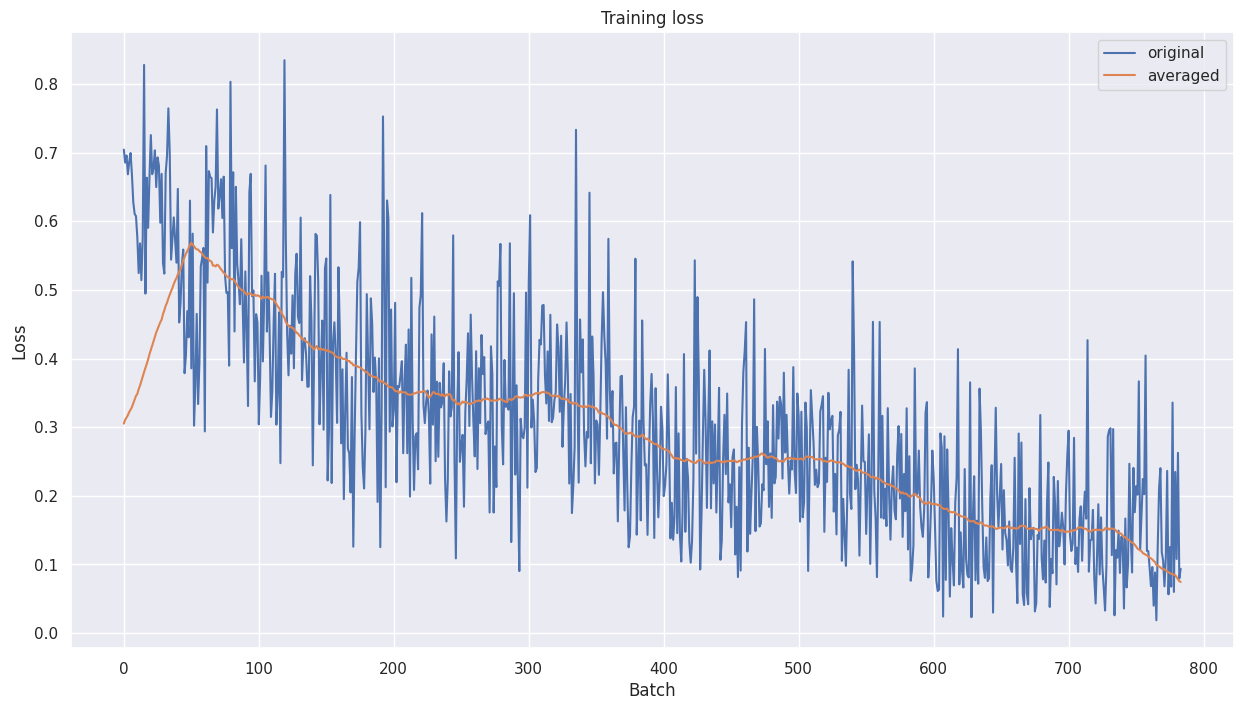

In [32]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()

## Evaluation

For a better measure of the quality of the model, let's see the model accuracy for the test reviews.

In [33]:
print('Test set:')
evaluate(test_dataloader)

Test set:
Accuracy: [2541/2977] 0.8535


0.8535438360765871

#### modification of the evaluate function to return the values of accuracy, classification report and confusion matrix on test_dataloader


Accuracy: [2541/2977] 0.8535
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      1996
           1       0.80      0.74      0.77       981

    accuracy                           0.85      2977
   macro avg       0.84      0.83      0.83      2977
weighted avg       0.85      0.85      0.85      2977



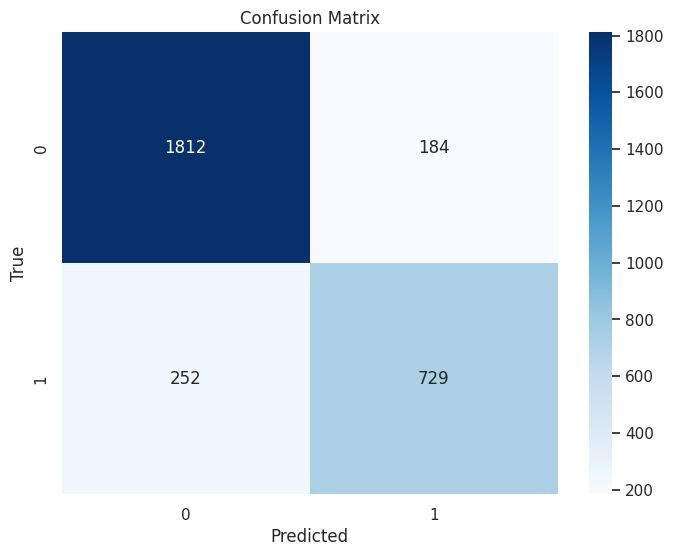

In [34]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(loader):
    model.eval()

    n_correct, n_all = 0, 0
    all_predictions = []
    all_labels = []

    for batch in loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)
            logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)

        labels = b_labels.to('cpu').numpy()
        n_correct += np.sum(predictions == labels)
        n_all += len(labels)

        # Collect predictions and labels for later analysis
        all_predictions.extend(predictions)
        all_labels.extend(labels)

    accuracy = n_correct / n_all

    # Print accuracy
    print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all, accuracy))

    # Create classification report
    class_report = classification_report(all_labels, all_predictions)
    print("Classification Report:\n", class_report)

    # Create confusion matrix and plot
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=[str(i) for i in range(conf_matrix.shape[1])],
                yticklabels=[str(i) for i in range(conf_matrix.shape[0])])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return accuracy, class_report, conf_matrix

# Usa la funzione evaluate con il tuo test_dataloader
accuracy, class_report, conf_matrix = evaluate(test_dataloader)
